In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from itertools import groupby
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2.2.2


In [138]:
base = '/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/lig47_data/'

df = pd.read_pickle(base + "lig47_hbonds_dict")

frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

dfaro = np.load(base + "aro_contacts.npy")

dcharges = np.load(base + "charge_dist_matrix.npy")
print(dcharges.shape)

hydrodf = pd.read_pickle(base + "hphbob_dict_lig47")

frames = [hydrodf[key]['distance'] for key in hydrodf.keys()]
hydrocombined = np.concatenate(frames, axis=1)
print(hydrocombined.shape)

dmat = np.load(base + "distance_matrix_full_LIG.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]


(1100889, 314)
(1100889, 9)
(1100889, 1500)
(1100889, 20)


In [134]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=4, whiten=True)

pca1.fit(combined)
hbond_pca = pca1.transform(combined)

pca2 = PCA(n_components=4, whiten=True)

pca2.fit(dcharges)
charges_pca = pca2.transform(dcharges)

pca3 = PCA(n_components=4, whiten=True)

pca3.fit(hydrocombined)
hydro_pca = pca3.transform(hydrocombined)

all_input = np.concatenate([dmat, hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)


In [135]:
print(all_input.shape)

(1110889, 35)


In [136]:
all_input = np.concatenate([hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)
print(all_input.shape)

(1110889, 15)


In [137]:
print(hydro_pca.shape)
print(charges_pca.shape)
print(hbond_pca.shape)
print(dfaro)

(1110889, 4)
(1110889, 4)
(1110889, 4)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [20]:
all_input = np.concatenate([hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)
print(all_input.shape)
pca_all12 = PCA(n_components=12, whiten=True)

pca_all12.fit(all_input)
inputs_pca12 = pca_all12.transform(all_input)

In [77]:
print(inputs_pca12.shape)

(1100889, 12)


In [62]:
inputs_pca = inputs_pca12

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_large = np.zeros(len(events_all))
avg_large = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

avg_large = avg_all[mapping_all > 466]
mapping_large = mapping_all[mapping_all > 466]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance input data of shape:", avg_5_476.shape)

print("Events above 476 frames:", len(mapping_large))
print("With avg distance input data of shape:", avg_large.shape)


mapping = mapping_5_476
avg = avg_5_476

N = len(mapping)
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

scaled = mapping/100
print("max log length:",np.max(mapping))
print("min log length:",np.min(mapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = scaled[train_indices]
a2 = std_avg[val_indices]
m2 = scaled[val_indices]
a3 = std_avg[test_indices]
m3 = scaled[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

std_largeavg = (avg_large - amean)/astd


avg_large = std_largeavg.reshape(std_largeavg.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

Total events: 32264
With avg distance input data of shape: (32264, 12)
Events between 5 and 476 frames: 11279
With avg distance input data of shape: (11279, 12)
Events above 476 frames: 337
With avg distance input data of shape: (337, 12)
max log length: 476.0
min log length: 5.0
mean: [ 0.40943175  0.05690649 -0.04869818 -0.18737298 -0.02461293  0.03894813
  0.04571338  0.1436296   0.02840343 -0.06309986 -0.28532895 -0.04234308]
std deviation: [0.71625841 0.94804536 0.93057493 0.78533701 0.78361265 0.74928589
 0.66164968 0.6815735  0.52710962 0.57761934 0.57624519 0.6918401 ]
standardized avg distance data
(7895, 12)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30116 | val_0_mse: 0.67729 |  0:00:00s
epoch 1  | loss: 0.66133 | val_0_mse: 0.53473 |  0:00:00s
epoch 2  | loss: 0.53448 | val_0_mse: 0.47418 |  0:00:01s
epoch 3  | loss: 0.47395 | val_0_mse: 0.46191 |  0:00:01s
epoch 4  | loss: 0.4477  | val_0_mse: 0.42907 |  0:00:01s
epoch 5  | loss: 0.44156 | val_0_mse: 0.3958  |  0:00:02s
epoch 6  | loss: 0.42745 | val_0_mse: 0.3969  |  0:00:02s
epoch 7  | loss: 0.40863 | val_0_mse: 0.40177 |  0:00:03s
epoch 8  | loss: 0.3953  | val_0_mse: 0.38882 |  0:00:03s
epoch 9  | loss: 0.4001  | val_0_mse: 0.37824 |  0:00:03s
epoch 10 | loss: 0.38585 | val_0_mse: 0.38543 |  0:00:03s
epoch 11 | loss: 0.37948 | val_0_mse: 0.36332 |  0:00:04s
epoch 12 | loss: 0.38024 | val_0_mse: 0.38151 |  0:00:04s
epoch 13 | loss: 0.36717 | val_0_mse: 0.35173 |  0:00:04s
epoch 14 | loss: 0.35712 | val_0_mse: 0.33806 |  0:00:05s
epoch 15 | loss: 0.34709 | val_0_mse: 0.31948 |  0:00:05s
epoch 16 | loss: 0.34651 | val_0_mse: 0.30851 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [63]:
print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[2.0202894  0.14946477 0.16984513 ... 0.05496582 0.27305877 1.5746726 ]
[0.44 0.1  0.08 ... 0.07 0.17 1.58]
49.47399
52.27925531914894


In [64]:
preds = clf.predict(avg_large)
preds = preds[:,0]

ap3 = preds*100
al3 = mapping_large

print(np.mean(ap3))
print(np.mean(al3))

257.2534
879.213649851632


r2: 0.7979665093860577


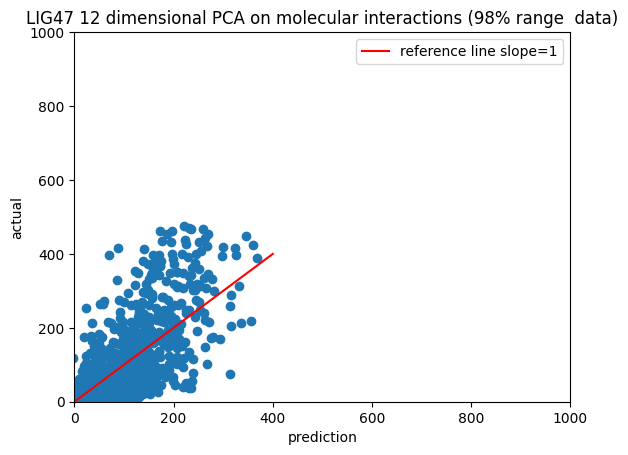

In [65]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 400,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 12 dimensional PCA on molecular interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,1000])
plt.ylim([0,1000])
plt.show()

r2: 0.7979665093860577


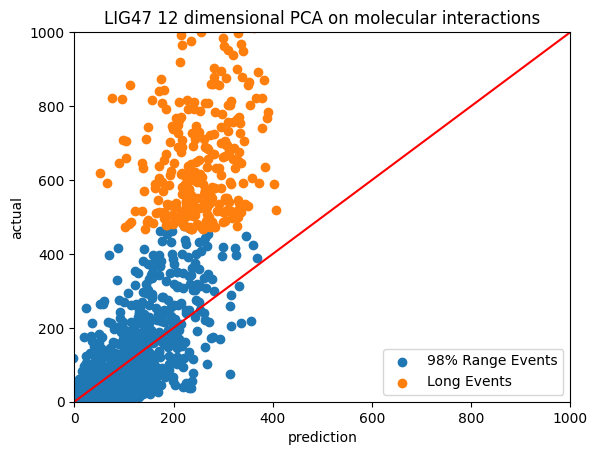

In [69]:
middle = plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 1000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
large = plt.scatter(ap3,al3)
plt.title("LIG47 12 dimensional PCA on molecular interactions")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,1000])
plt.ylim([0,1000])
plt.legend((middle, large),
           ('98% Range Events', 'Long Events'))
plt.show()

Text(0.5, 1.0, 'Distribution of Percent Error for Prediction')

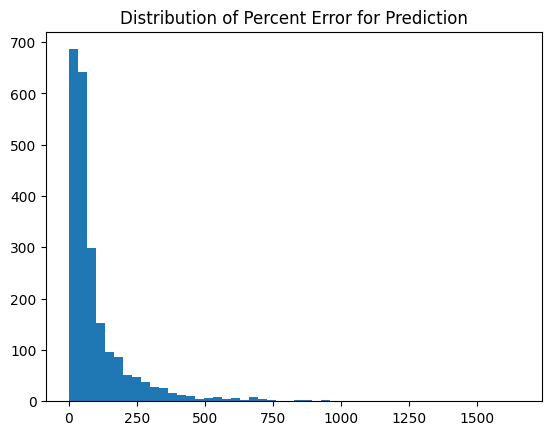

In [28]:
plt.hist(100 * abs(al2-ap2) / al2, bins=50)
plt.title("Distribution of Percent Error for Prediction")

Text(0.5, 0, 'Ordered Longest Events')

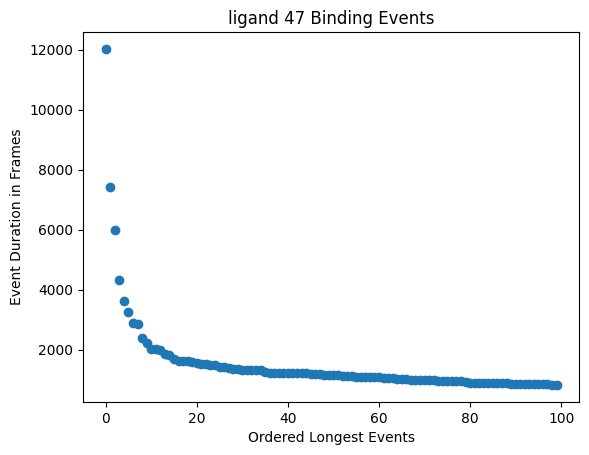

In [115]:
plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

plt.scatter(np.arange(100), plotevents[:100])
plt.title("ligand 47 Binding Events") 
plt.ylabel("Event Duration in Frames")
plt.xlabel("Ordered Longest Events")

In [139]:
base = '/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/fasudil_data/'

df = pd.read_pickle(base + "fasudil_hbonds_dict")

frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

dfaro = np.load(base + "aro_contacts.npy")

dcharges = np.load(base + "charge_dist_matrix.npy")
print(dcharges.shape)

hydrodf = pd.read_pickle(base + "hphob_dict_fasudil")

frames = [hydrodf[key]['distance'] for key in hydrodf.keys()]
hydrocombined = np.concatenate(frames, axis=1)
print(hydrocombined.shape)

dmat = np.load(base + "distance_matrix_full_FAS.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

(1110889, 288)
(1110889, 9)
(1110889, 1400)
(1110889, 20)


In [119]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=4, whiten=True)

pca1.fit(combined)
hbond_pca = pca1.transform(combined)

pca2 = PCA(n_components=4, whiten=True)

pca2.fit(dcharges)
charges_pca = pca2.transform(dcharges)

pca3 = PCA(n_components=4, whiten=True)

pca3.fit(hydrocombined)
hydro_pca = pca3.transform(hydrocombined)

all_input = np.concatenate([dmat, hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)

In [120]:
all_input = np.concatenate([hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)
print(all_input.shape)
pca_all12 = PCA(n_components=12, whiten=True)

pca_all12.fit(all_input)
inputs_pca12 = pca_all12.transform(all_input)

(1110889, 15)


In [140]:
events_all = combined_residence_events(dmat)

In [121]:
inputs_pca = inputs_pca12

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(inputs_pca[0,:])])
mapping_large = np.zeros(len(events_all))
avg_large = np.zeros([len(events_all), len(inputs_pca[0,:])])

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

avg_large = avg_all[mapping_all > 466]
mapping_large = mapping_all[mapping_all > 466]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance input data of shape:", avg_5_476.shape)

print("Events above 476 frames:", len(mapping_large))
print("With avg distance input data of shape:", avg_large.shape)


mapping = mapping_5_476
avg = avg_5_476

N = len(mapping)
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

scaled = mapping/100
print("max log length:",np.max(mapping))
print("min log length:",np.min(mapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

a1 = std_avg[train_indices]
m1 = scaled[train_indices]
a2 = std_avg[val_indices]
m2 = scaled[val_indices]
a3 = std_avg[test_indices]
m3 = scaled[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

std_largeavg = (avg_large - amean)/astd


avg_large = std_largeavg.reshape(std_largeavg.shape[0], -1)

print(a1.shape)

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf2 = TabNetRegressor()
clf2.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf2.predict(a3)
preds = preds[:,0]

Total events: 48714
With avg distance input data of shape: (48714, 12)
Events between 5 and 476 frames: 18223
With avg distance input data of shape: (18223, 12)
Events above 476 frames: 84
With avg distance input data of shape: (84, 12)
max log length: 474.0
min log length: 5.0
mean: [-0.04997513  0.01137689 -0.04180839  0.12062974 -0.0463235   0.15257585
  0.01000535  0.20165215 -0.07304592 -0.09729313 -0.14765729 -0.09246002]
std deviation: [0.74250177 0.99481179 0.86567075 0.8589726  0.77974064 0.78466764
 0.71530996 0.71846548 0.59569427 0.57446402 0.57674326 0.62979364]
standardized avg distance data
(12756, 12)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66774 | val_0_mse: 0.32638 |  0:00:00s
epoch 1  | loss: 0.30431 | val_0_mse: 0.23951 |  0:00:01s
epoch 2  | loss: 0.27234 | val_0_mse: 0.22472 |  0:00:02s
epoch 3  | loss: 0.26335 | val_0_mse: 0.21683 |  0:00:02s
epoch 4  | loss: 0.25983 | val_0_mse: 0.21102 |  0:00:03s
epoch 5  | loss: 0.25229 | val_0_mse: 0.20096 |  0:00:03s
epoch 6  | loss: 0.24678 | val_0_mse: 0.20098 |  0:00:04s
epoch 7  | loss: 0.24073 | val_0_mse: 0.19621 |  0:00:04s
epoch 8  | loss: 0.23168 | val_0_mse: 0.19066 |  0:00:05s
epoch 9  | loss: 0.22806 | val_0_mse: 0.18662 |  0:00:05s
epoch 10 | loss: 0.2324  | val_0_mse: 0.18658 |  0:00:06s
epoch 11 | loss: 0.2241  | val_0_mse: 0.18567 |  0:00:06s
epoch 12 | loss: 0.2214  | val_0_mse: 0.18307 |  0:00:06s
epoch 13 | loss: 0.22393 | val_0_mse: 0.18043 |  0:00:07s
epoch 14 | loss: 0.21769 | val_0_mse: 0.17703 |  0:00:07s
epoch 15 | loss: 0.21121 | val_0_mse: 0.16864 |  0:00:08s
epoch 16 | loss: 0.20765 | val_0_mse: 0.17316 |  0:00:08s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Text(0.5, 0, 'Ordered Longest Events')

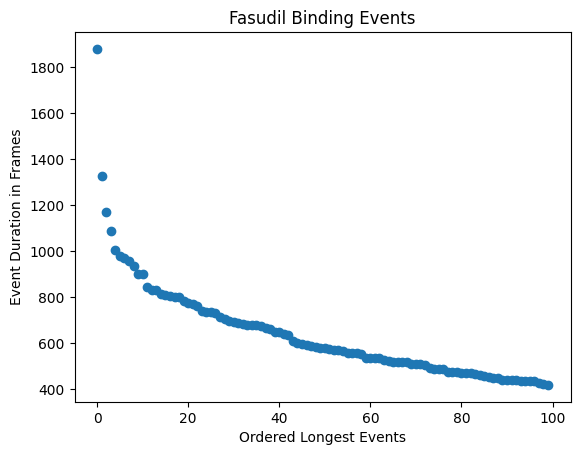

In [141]:
plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

plt.scatter(np.arange(100), plotevents[:100])
plt.title("Fasudil Binding Events") 
plt.ylabel("Event Duration in Frames")
plt.xlabel("Ordered Longest Events")

In [122]:
print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[0.4922459  1.3790091  0.18865834 ... 0.21674684 0.35018593 0.17470826]
[1.02 2.2  0.08 ... 0.11 0.49 0.13]
39.616177
40.00877914951989


In [123]:
preds = clf2.predict(avg_large)
preds = preds[:,0]

ap3 = preds*100
al3 = mapping_large

print(np.mean(ap3))
print(np.mean(al3))

199.73575
682.1071428571429


r2: 0.7152661159131428


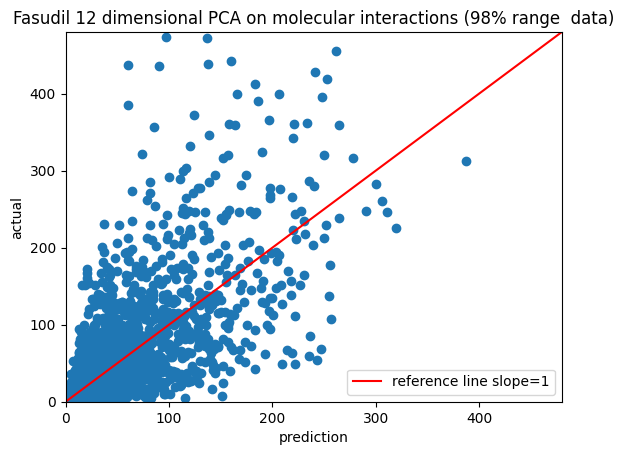

In [133]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 480,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Fasudil 12 dimensional PCA on molecular interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,480])
plt.ylim([0,480])
plt.show()

Text(0.5, 1.0, 'Distribution of Percent Error for Prediction (Fasudil)')

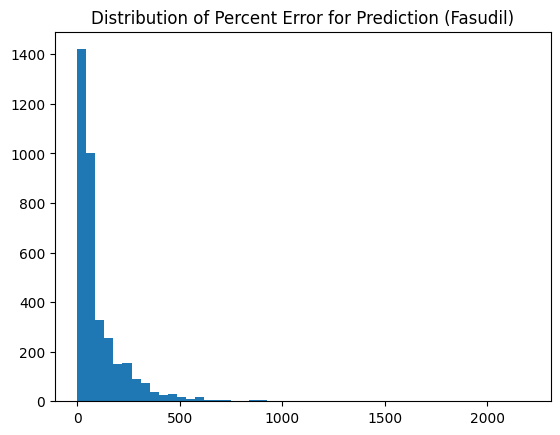

In [128]:
plt.hist(100 * abs(al2-ap2) / al2, bins=50)
plt.title("Distribution of Percent Error for Prediction (Fasudil)")